In [ ]:
!pip install SuperSuit
!pip install ray[rllib]==0.8.5
!pip install lz4
!pip install opencv-python>=3.4
!pip install dm_tree
!pip install stable-baselines3
!pip install pettingzoo
!pip install sb3-contrib
!pip install gym==0.23.1
!pip install wandb

In [1]:
import numpy as np

from social_dilemmas.envs.pettingzoo_env import MAX_CYCLES
from social_dilemmas.envs.pettingzoo_env import env as aec_env
from social_dilemmas.envs.pettingzoo_env import parallel_env
from pettingzoo.test import parallel_api_test

In [2]:
from social_dilemmas.envs.generate_map import create_map

env = aec_env(env = "harvest", num_agents = 2, proportion=0.5)
env.reset()
n_act = env.action_space(env.agents[0]).n

In [3]:
def show_state(env, img, cummulative_reward, step=0, info=""):
    img.set_data(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s | Reward: %r" % (env.metadata['name'],step, info, cummulative_reward))
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)

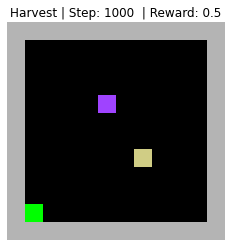

In [4]:
import matplotlib.pyplot as plt

from IPython import display
from random import randint

img = plt.imshow(env.render(mode='rgb_array'))
counter = 0
cummulative_reward = 0
for agent in env.agent_iter(1000):
    counter += 1
    obs, reward, done, info = env.last()        
    cummulative_reward += reward
    action = randint(0,n_act-1) if not done else None
    env.step(action)
    show_state(env, img, cummulative_reward, counter)

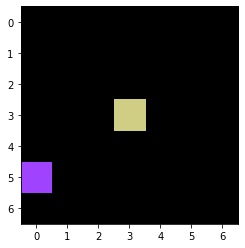

In [5]:
import matplotlib.pyplot as plt

img = plt.imshow(obs)

In [ ]:
for agent in env.agent_iter(MAX_CYCLES * env.num_agents):
    _,_,done,_ = env.last()
    action = randint(0,n_act-1) if not done else None
    env.step(action)
    if not env.agents:
        env.reset()
# api_test(env, MAX_CYCLES)

In [ ]:
env = parallel_env(max_cycles=MAX_CYCLES, env = "harvest", num_agents = 10, proportion=0.7)
env.reset()
n_act = env.action_space(env.agents[0]).n
for _ in range(MAX_CYCLES * env.num_agents):
    actions = {agent: np.random.randint(n_act) for agent in env.agents}
    _, _, _, _ = env.step(actions)
    if not env.agents:
        _ = env.reset()
parallel_api_test(env, MAX_CYCLES)

In [ ]:
from stable_baselines3.ppo import CnnPolicy, MlpPolicy
from stable_baselines3 import A2C
import supersuit as ss
import wandb

wandb.login()

In [ ]:
from stable_baselines3.common.vec_env import VecMonitor

num_agents = 2
number_of_envs = 8
env = parallel_env(max_cycles=MAX_CYCLES, env = "harvest", num_agents = num_agents, proportion=.5)

# env = ss.color_reduction_v0(env, mode="full")
# env = ss.resize_v1(env, x_size=60, y_size=60)
env = ss.frame_stack_v1(env, 1)
env = ss.pettingzoo_env_to_vec_env_v1(env)

env = ss.concat_vec_envs_v1(env, number_of_envs, num_cpus=4, base_class="stable_baselines3")
env = VecMonitor(env, info_keywords=('Utilitarian',), filename='logs/')

model = A2C(
    CnnPolicy,
    env,
    verbose=3,
    tensorboard_log="runs/A2C")

In [ ]:
wandb.init(
    name="A2C",
    project="sb3",
    config={"policy_type": "MlpPolicy", "total_timesteps": 100000},
    sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
    monitor_gym=False,  # auto-upload the videos of agents playing the game
)

In [3]:
from wandb.integration.sb3 import WandbCallback

class UtilitarianCallBack(WandbCallback):
    def __init__(self, verbose=0):
        super(UtilitarianCallBack, self).__init__(verbose)
    def _on_training_start(self):
        self._log_freq = 1000  # log every 200 calls
    def _on_step(self) -> bool:
        if self.n_calls % self._log_freq == 0:
            uti = sum(item['Utilitarian'] for item in self.locals['infos'])/(number_of_envs*num_agents) # <- number of env running at the same time, number of agents
            eq = sum(item['Equality'] for item in self.locals['infos'])/(number_of_envs*num_agents)
            sus = sum(item['Sustainability'] for item in self.locals['infos'])/(number_of_envs*num_agents)
            self.logger.record('custom/utilitarian', uti)
            self.logger.record('custom/equality', eq)
            self.logger.record('custom/sustainability', sus)
        return True

In [2]:
model.learn(total_timesteps=1000000,     
            callback=UtilitarianCallBack())

/home/miguel/anaconda3/envs/social/lib/python3.7/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


NameError: name 'model' is not defined

In [ ]:
model.save("policy")

In [ ]:
from matplotlib import animation

def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):
    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1], frames[0].shape[0]))

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)

In [ ]:
env = aec_env(env = "harvest", num_agents = 2, proportion=.5)
# env = ss.color_reduction_v0(env, mode="full")
# env = ss.resize_v1(env, x_size=60, y_size=60)
env = ss.frame_stack_v1(env, 1)
model = A2C.load("policy")

In [ ]:
import matplotlib.pyplot as plt

from IPython import display
from random import randint


env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
counter = 0
cummulative_reward = 0

for agent in env.agent_iter(1000):
    counter += 1
    obs, reward, done, info = env.last()        
    cummulative_reward += reward
    action = model.predict(obs, deterministic=True)[0] if not done else None
    env.step(action)
    show_state(env, img, cummulative_reward, counter)

In [ ]:
img = plt.imshow(obs)